# Data import and preparation

In [56]:
import pandas as pd
from os.path import join
from os.path import sep
from Bio import SeqIO

import matplotlib.pyplot as plt
from IPython.display import Image

Let's download the data. **If you use Windows, then for full compatibility with this notebook code, use [WSL](https://learn.microsoft.com/en-us/windows/wsl/install)**.
Or just download the necessary files manually from [this link](https://drive.google.com/drive/folders/1uYRlDXXQBM_-gNHU_QpYcQQcN5wS0al9?usp=sharing).

Note that these dataset are distributed under the **Creative Commons Attribution-Non-commercial-ShareAlike 3.0 Unported license**!

In [43]:
%%bash
mkdir -p ./preprocessed_data

mkdir -p ./fig
wget --quiet -O ./fig/fig1.png 'https://docs.google.com/uc?export=download&id=1aghsPzi1qv6QMsCZFf5wjgNNIaH7wtQ5'

mkdir -p ./psp_data
wget --quiet -O ./psp_data/Acetylation_db.tsv 'https://docs.google.com/uc?export=download&id=1Tvl20HAjJIhoAZWKAmkSfpU8nJ21Cdpa'
wget --quiet -O ./psp_data/LICENSE 'https://docs.google.com/uc?export=download&id=1DSa4Oe8yM9AD6KhvPBXrLINif7YeCAlk'
wget --quiet -O ./psp_data/legalcode.txt 'https://docs.google.com/uc?export=download&id=17p5LRaefsZIkGPqzHLw0dadaADMJSBYf'
wget --quiet -O ./psp_data/psp_prot.fa 'https://docs.google.com/uc?export=download&id=16Fm-Z_xUVv-hRDADsMwg3Jl6PRAnyKRv'

## formatting

Selecting records about H. Sapiens from the dataset.

In [50]:
# data import
df = pd.read_csv(join('.','psp_data', 'Acetylation_db.tsv'),
                 sep='\t', index_col= None)

# H.Sapins data selection, reindexing
df_human = df[df['ORGANISM'] == 'human']
df_human.reset_index(inplace=True, drop=True)
df_human = df_human[['PROTEIN', 'ACC_ID', 'MOD_RSD',
                     'SITE_GRP_ID', 'ORGANISM', 'DOMAIN',
                     'LT_LIT', 'MS_LIT', 'MS_CST']]

del df

display(df_human.head(2))
print('.\n'*5)
display(df_human.tail(2))

,PROTEIN,ACC_ID,MOD_RSD,SITE_GRP_ID,ORGANISM,DOMAIN,LT_LIT,MS_LIT,MS_CST
0,14-3-3 beta,P31946,K5-ac,33347661,human,NaN,NaN,2.0,NaN
1,14-3-3 beta,P31946,K13-ac,36297548,human,14-3-3,NaN,1.0,14.0


.
.
.
.
.



,PROTEIN,ACC_ID,MOD_RSD,SITE_GRP_ID,ORGANISM,DOMAIN,LT_LIT,MS_LIT,MS_CST
23093,ZZZ3,Q8IYH5,K725-ac,11323834,human,NaN,NaN,1.0,NaN
23094,ZZZ3,Q8IYH5,K738-ac,11323831,human,NaN,NaN,1.0,NaN


Here it is performed:
* changing the `MOD_RSD` value from "K5-ac" format to 5
* counting number of experimental confirmations for sites

In [16]:
# creating a counter to count the number
# of experimental confirmations

counter =  {i : 0 for i in range(1, 6)}
max_val = max(counter.keys())
counter['>5'] = 0

for i in df_human.index:

    # change MOD_RSD from "K5-ac" to 5
    df_human['MOD_RSD'].at[i] = int(df_human['MOD_RSD'].at[i].split('-')[0][1:])

    # to count the number of experimental confirmations
    exp_num = df_human[['LT_LIT','MS_LIT','MS_CST']].loc[i].sum()
    if exp_num <= max_val:
        counter[exp_num] += 1
    else:
        counter['>5'] += 1

df_human['MOD_RSD'] = df_human['MOD_RSD'].astype('int')

The barplot of experimental confirmations:

Text(0, 0.5, 'counts')

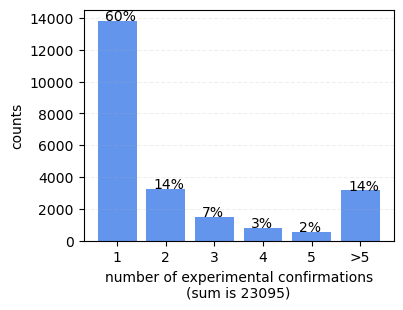

In [17]:
fig1, ax1 = plt.subplots(1, 1, figsize=(4,3))
all_records = sum(counter.values())

ax1.bar(x=[i for i in range(6)],
        height=[counter[i] for i in counter.keys()],
        tick_label=[str(i) for i in counter.keys()],
        color='#6495ED')

[ax1.text(x=x-0.25,
      y=counter[y] + 20,
      s=f'{int(round((counter[y]/all_records)*100, 0))}%') 
      for x, y in zip(range(6), counter.keys())
]

ax1.grid(alpha=0.2, ls='--', axis='y')
ax1.set_xlabel(f'number of experimental confirmations\n(sum is {all_records})')
ax1.set_ylabel('counts')

## Extracting PTMs Sites 1

Let's create hash-table for fast indexing

In [23]:
positions_dict = {key : list() for key in df_human['ACC_ID'].unique()}

for i in df_human.index:
   positions_dict[df_human['ACC_ID'].loc[i]].append(df_human['MOD_RSD'].loc[i])

demonstration: 
* key is ACC_ID;
* value is acetyl-lysine position;

In [25]:
for key in list(positions_dict.keys())[:5]:
    print(key, " \t:\t", positions_dict[key])

P31946  	:	 [5, 13, 51, 70, 77, 82, 117, 122, 159, 214]
P31946-2  	:	 [49]
P62258  	:	 [12, 28, 50, 69, 78, 106, 118, 123, 142, 153, 215]
Q04917  	:	 [50, 69, 120, 125, 142, 155, 217]
P61981  	:	 [50, 69, 120, 125, 142, 152, 162, 217]


### Creating an ACC_ID file(additional)

You may use this code for generating the `ACC_ID file`, if you need custom file. We use `ACC_ID file` for ID MAPPING and extraction of protein sequences and their isoforms. To get a reproducible result, you can use the provided sequence fasta file (`psp_prot.fa`).

In [19]:
"""
id_set = set()
for key in positions_dict.keys():
    if '-' in key:
        id_set.add(key.split('-')[0])
    else:
        id_set.add(key)

pd.Series(list(id_set)).to_csv('join('.','ACC_ID.csv'), sep='\t', index=None, header=None)
"""

## Extracting PTMs Sites 2

In [51]:
seq_dict = dict()

for record in SeqIO.parse(join('.', 'psp_data', 'psp_prot.fa'), "fasta"):
    ACC_ID = record.id.split('|')[1]
    seq_dict[ACC_ID] = record.seq

demonstration: 
* key is ACC_ID;
* value is sequence;

In [52]:
print(key, " \t:\t", seq_dict[key])

P61981  	:	 MVDREQLVQKARLAEQAERYDDMAAAMKNVTELNEPLSNEERNLLSVAYKNVVGARRSSWRVISSIEQKTSADGNEKKIEMVRAYREKIEKELEAVCQDVLSLLDNYLIKNCSETQYESKVFYLKMKGDYYRYLAEVATGEKRATVVESSEKAYSEAHEISKEHMQPTHPIRLGLALNYSVFYYEIQNAPEQACHLAKTAFDDAIAELDTLNEDSYKDSTLIMQLLRDNLTLWTSDQQDDDGGEGNN


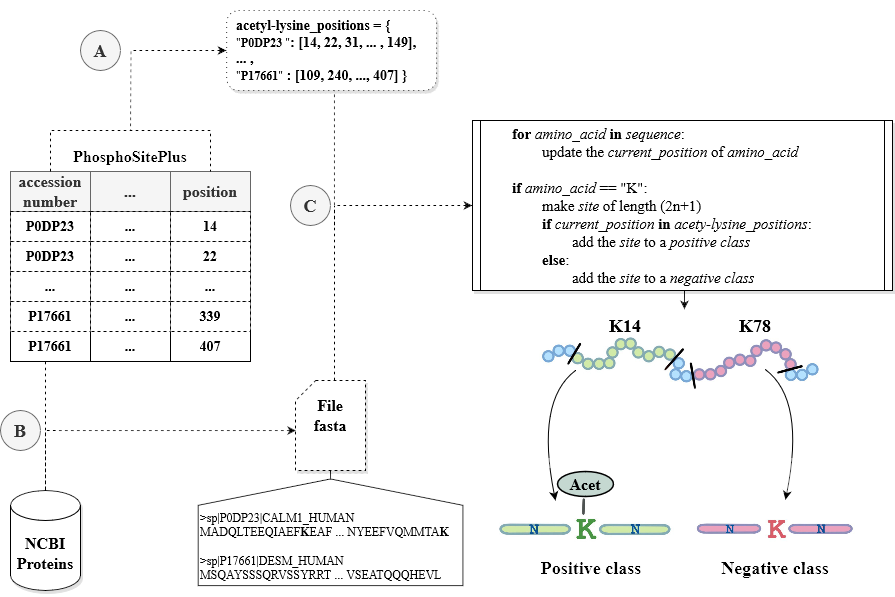

In [53]:
Image(join('.', 'fig', 'fig1.png'))

Handler below:

In [58]:
def fasta2csv(output:str, path:str=f'.{sep}preprocessed_data', seq_dict=None, positions_dict=None, length=35, sep="\t"):

    # must define hash tables for this function
    assert seq_dict is not None or positions_dict is not None, 'Add the appropriate hash tables for' +\
                                                               ' the sequences and acetyllysin positions.'
    drop_site_count = 0
    
    assert (length-1)%2 == 0, 'the length of the site must be odd!'
    h_len = int((length-1)/2)

    # output formatting
    with open( join(path, output), "w") as f:
        f.write("AC\tLOC\tCOND\tSITE\tDESCRIPTOR\n")
        
        for ACC_ID in positions_dict.keys():
            # check that we have seq for current ACC_ID
            seq = seq_dict.get(ACC_ID, False)
            if seq:
                
                for i_0b, aa in enumerate(seq):
                    # i_0b -- zero-based index
                    # i_1b -- one-based index
                    i_1b = i_0b + 1

                    # program must to cut a subsequence with 
                    # a centrally located lysine
                    # if current amino acid is Lys
                    if aa == "K":

                        # if site len < length drop subsequence (it may be in N-, C-end of protein)
                        if i_0b-h_len < 0 or (i_0b+h_len)+1 >= len(seq):
                            drop_site_count += 1
                            continue
                                
                        else:
                            
                            # cut a subsequence with a centrally located lysine 
                            # length == (2n+1), n == h_len
                            SITE = seq[i_0b-h_len:(i_0b+h_len)+1]
                            
                            # program must to remove the subsequence with 
                            # a centrally located lysine
                            # if it contains selenocysteine or pyrrolysine
                            if "U, O" in SITE:
                                continue

                            # write record ro csv
                            LOC = i_1b
                            CONDITION = 1 if LOC in positions_dict[ACC_ID] else 0
                            f.write(f"{ACC_ID}\t{LOC}\t{CONDITION}\t{SITE}\t{ACC_ID};{LOC};{CONDITION}\n")
            
            else:
                print(f'ACC ID {ACC_ID} not found in sequence dict!')
                continue
        print(f'\nsubsequence with a centrally located lysine was droped: {drop_site_count}')

Let's generate a csv file that will be used as input when generating a SDF.
* Some sequences from the position hash table are not represented in the sequence hash table. This is a consequence of errors in the indexing of the PhosphositePlus database (some indexes are no longer relevant).

In [59]:
fasta2csv('Acetylation_L35.csv', seq_dict=seq_dict, positions_dict=positions_dict)

ACC ID Q4W5N1 not found in sequence dict!
ACC ID Q6DRA9 not found in sequence dict!
ACC ID B4E030 not found in sequence dict!
ACC ID AAA58698 not found in sequence dict!
ACC ID P08567_VAR_R340K not found in sequence dict!
ACC ID Q16821_VAR_N476K not found in sequence dict!
ACC ID A2RUF3 not found in sequence dict!
ACC ID Q8NG57 not found in sequence dict!
ACC ID Q3SY89 not found in sequence dict!
ACC ID A6NLF2 not found in sequence dict!
ACC ID H0YL09 not found in sequence dict!
ACC ID P62988 not found in sequence dict!
ACC ID Q96N22_VAR_L295S not found in sequence dict!

subsequence with a centrally located lysine was droped: 17483


Result:

In [60]:
display(pd.read_csv('./preprocessed_data/Acetylation_L35.csv', index_col=None, sep='\t'))

,AC,LOC,COND,SITE,DESCRIPTOR
0,P31946,29,0,AKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLL,P31946;29;0
1,P31946,51,1,QGHELSNEERNLLSVAYKNVVGARRSSWRVISSIE,P31946;51;1
2,P31946,70,1,VVGARRSSWRVISSIEQKTERNEKKQQMGKEYREK,P31946;70;1
3,P31946,76,0,SSWRVISSIEQKTERNEKKQQMGKEYREKIEAELQ,P31946;76;0
4,P31946,77,1,SWRVISSIEQKTERNEKKQQMGKEYREKIEAELQD,P31946;77;1
...,...,...,...,...,...
350648,Q8IYH5,802,0,MYRNLPEYKELLQFKKLKKQKLQQMQAESGFVQHV,Q8IYH5;802;0
350649,Q8IYH5,803,0,YRNLPEYKELLQFKKLKKQKLQQMQAESGFVQHVG,Q8IYH5;803;0
350650,Q8IYH5,805,0,NLPEYKELLQFKKLKKQKLQQMQAESGFVQHVGFK,Q8IYH5;805;0
350651,Q8IYH5,822,0,KLQQMQAESGFVQHVGFKCDNCGIEPIQGVRWHCQ,Q8IYH5;822;0
